In [34]:
import numpy as np
import torch
import joblib
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

In [35]:
features = ["18 to 64 years poverty [%]", "18 years and over [%]",
    "65 years and over [%]", "65 years and over poverty [%]",
    "All parents in family in labor force [%]",
    "American Indian and Alaska Native [%]", "Armed Forces [%]",
    "Asian [%]", "Black or African American [%]",
    "Civilian labor force [%]", "Commuting: individual car [%]",
    "Commuting: public transport [%]", "Commuting: work from home [%]",
    "Education: 9th-12th (no diploma) [%]", "Education: <9th grade [%]",
    "Education: associate's degree [%]", "Education: bachelor's degree [%]",
    "Education: bachelor's degree or higher [%]",
    "Education: graduate or professional degree [%]",
    "Education: high school graduate [%]",
    "Education: high school graduate or higher [%]",
    "Education: some college (no degree) [%]",
    "Female civilian labor force [%]", "Foreign-born [%]",
    "Foreign-born: naturalized [%]", "Gross rent <25% of income [%]",
    "Gross rent >=25% of income [%]",
    "Health insurance coverage (noninstitutionalized) [%]",
    "Hispanic or Latino [%]", "Homeowner vacancy rate [%]",
    "Households: Female (no spouse) [%]",
    "Households: Male (no spouse) [%]", "Households: married-couple [%]",
    "Households: with broadband [%]", "Households: with computer [%]",
    "Housing units with a mortgage [%]",
    "Labor force by industry: agriculture, forestry, fishing, hunting, mining [%]",
    "Labor force by industry: arts, entertainment, recreation, accommodation, food services [%]",
    "Labor force by industry: construction [%]",
    "Labor force by industry: education, health care, social assistance [%]",
    "Labor force by industry: finance, insurance, real estate, rental, leasing [%]",
    "Labor force by industry: information [%]",
    "Labor force by industry: manufacturing [%]",
    "Labor force by industry: other services [%]",
    "Labor force by industry: professional, scientific, management, admin, waste management services [%]",
    "Labor force by industry: public administration [%]",
    "Labor force by industry: retail trade [%]",
    "Labor force by industry: transportation, warehousing, utilities [%]",
    "Labor force by industry: wholesale trade [%]", "Land area (km²)",
    "Limited English speakers [%]", "Male [%]",
    "Mean travel time to work (min)", "Median age",
    "Median full-time earnings gender ratio (F/M) [%]",
    "Median household income ($)", "Moved: different county [%]",
    "Moved: different house [%]", "Moved: different state [%]",
    "Moved: within U.S. [%]",
    "Owner costs <25% of income (with mortgage) [%]",
    "Owner costs <25% of income (without mortgage) [%]",
    "Owner costs >=25% of income (with mortgage) [%]",
    "Owner costs >=25% of income (without mortgage) [%]",
    "Rental vacancy rate [%]", "Total households", "Total housing units",
    "Total population", "Under 18 years poverty [%]",
    "Unemployment Rate [%]", "Vacant housing units [%]", "Water area (km²)",
    "White [%]"]

In [36]:
loaded = np.load("../../Data/Data/data_x.npz", allow_pickle=True)
dict_x = {key: loaded[key] for key in loaded.files}

loaded = np.load("../../Data/Data/data_y.npz", allow_pickle=True)
dict_y = {key: loaded[key] for key in loaded.files}

In [37]:
years = np.array(range(2012, 2024))

In [38]:
def data_by_year(dict_x, dict_y):
    all_keys = list(dict_x.keys())
    data_by_year_x = []
    data_by_year_y = []

    for y in range(len(years)):
        data_year_x = []
        data_year_y = []
        for id in all_keys:
            data_year_x.append(dict_x[id][y])
            data_year_y.append(dict_y[id][y])
        tensor_x = torch.tensor(np.stack(data_year_x), dtype=torch.float32)
        tensor_y = torch.tensor(np.array(data_year_y), dtype=torch.float32).unsqueeze(1)
        data_by_year_x.append(tensor_x)
        data_by_year_y.append(tensor_y)

    print(len(data_by_year_x), data_by_year_x[0].shape)
    print(len(data_by_year_y), data_by_year_y[0].shape)

    return (data_by_year_x, data_by_year_y)

In [39]:
def data_by_county(dict_x, dict_y):
    all_keys = list(dict_x.keys())
    data_by_county_x = []
    data_by_county_y = []

    for id in all_keys:
        tensor_x = torch.tensor(dict_x[id], dtype=torch.float32)
        tensor_y = torch.tensor(dict_y[id], dtype=torch.float32).unsqueeze(1)
        data_by_county_x.append(tensor_x)
        data_by_county_y.append(tensor_y)

    print(len(data_by_county_x), data_by_county_x[0].shape)
    print(len(data_by_county_y), data_by_county_y[0].shape)

    return (data_by_county_x, data_by_county_y)

In [40]:
scaler_dol_y = joblib.load("../../Data/Data/scaler_y.pkl")

model_dol = torch.jit.load("../../Model/Model/model.pt")
model_dol.eval()

RecursiveScriptModule(
  original_name=RNN_Regressor
  (lstm): RecursiveScriptModule(original_name=LSTM)
  (dense1): RecursiveScriptModule(original_name=Linear)
  (dense2): RecursiveScriptModule(original_name=Linear)
)

In [41]:
def scorer(data_by_x, data_by_y):
    m_output_list = []
    m_data_y_list = []
    r2_list = []
    mae_list = []
    std_list = []

    for data_x, data_y in zip(data_by_x, data_by_y):
        with torch.no_grad(): 
            output = model_dol(data_x)
            output = scaler_dol_y.inverse_transform(output)
            data_y = scaler_dol_y.inverse_transform(data_y)
            errors = data_y - output

            m_output_list.append(np.mean(output))
            m_data_y_list.append(np.mean(data_y))

            r2_list.append(r2_score(data_y, output))

            mae_list.append(np.mean(np.abs(errors), axis=0))
            std_list.append(np.std(np.abs(errors), axis=0, ddof=1))

    m_output_list = np.array(m_output_list).flatten()
    m_data_y_list = np.array(m_data_y_list).flatten()
    r2_list = np.array(r2_list).flatten()
    mae_list = np.array(mae_list).flatten()
    std_list = np.array(std_list).flatten()
    
    return (m_output_list, m_data_y_list, r2_list, mae_list, std_list)

In [42]:
data_by_year_x, data_by_year_y = data_by_year(dict_x, dict_y)
data_by_county_x, data_by_county_y = data_by_county(dict_x, dict_y)

12 torch.Size([3096, 3, 73])
12 torch.Size([3096, 1])
3096 torch.Size([12, 3, 73])
3096 torch.Size([12, 1])


In [43]:
m_output_by_year, m_data_y_by_year, r2_by_year, mae_by_year, std_by_year = scorer(data_by_year_x, data_by_year_y)
m_output_by_county, m_data_y_by_county, r2_by_county, mae_by_county, std_by_county = scorer(data_by_county_x, data_by_county_y)

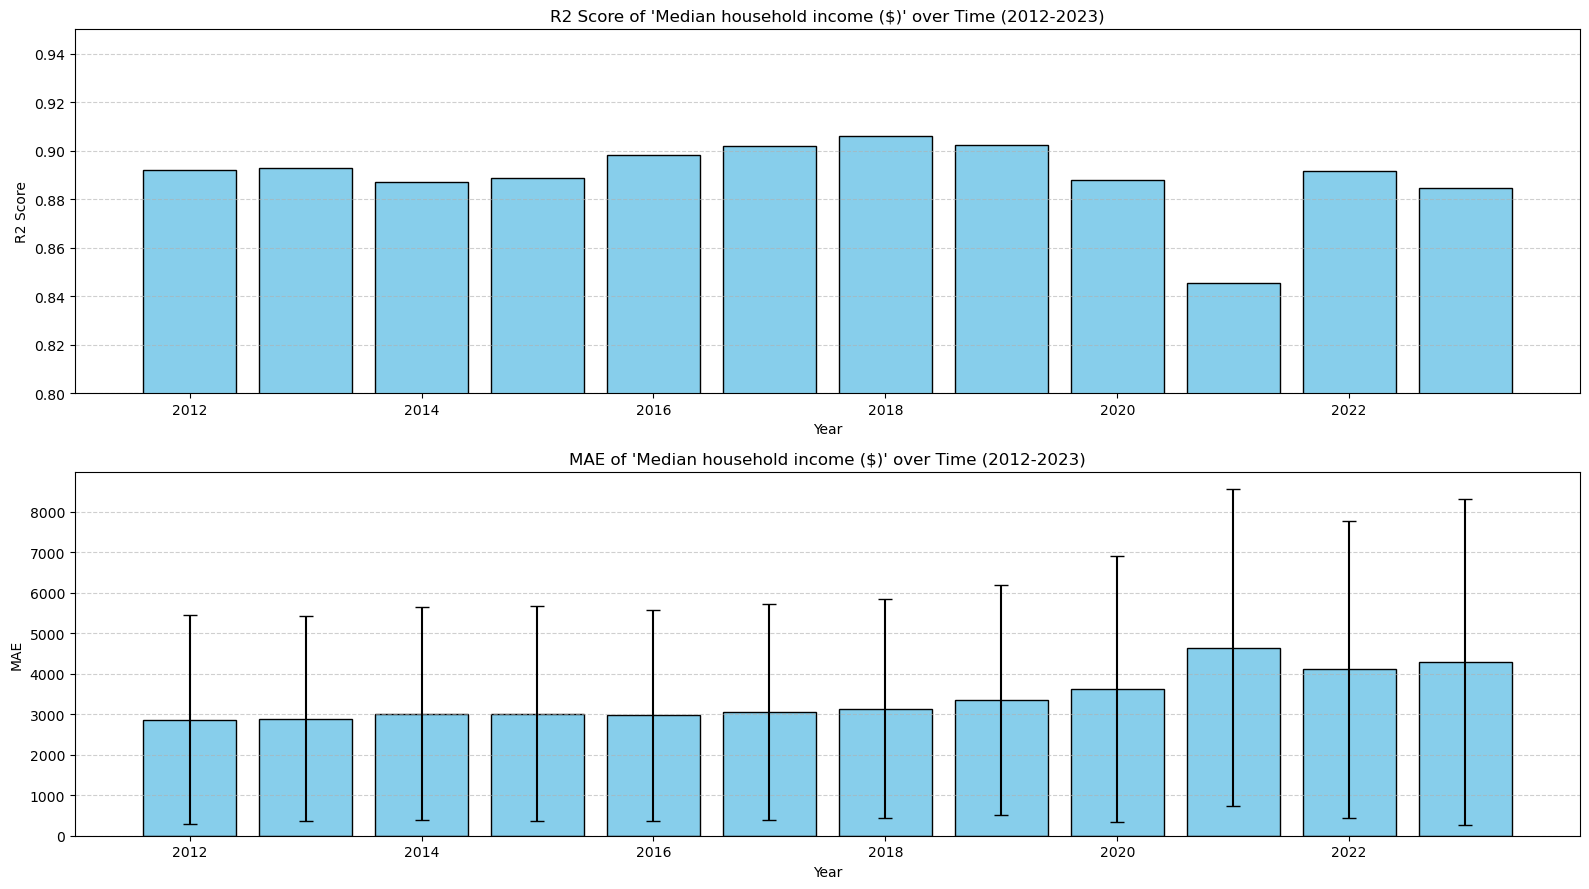

In [72]:
fig, ax = plt.subplots(2, 1, figsize=(16, 9))
ax = ax.flatten()

ax[0].bar(years, r2_by_year, capsize=5, color="skyblue", edgecolor="black")
ax[1].bar(years, mae_by_year, yerr=std_by_year, capsize=5, color="skyblue", edgecolor="black")

ax[0].set_ylim(0.8, 0.95)

ax[0].grid(True, axis='y', linestyle='--', alpha=0.6)
ax[1].grid(True, axis='y', linestyle='--', alpha=0.6)

ax[0].set_title("R2 Score of 'Median household income ($)' over Time (2012-2023)")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("R2 Score")

ax[1].set_title("MAE of 'Median household income ($)' over Time (2012-2023)")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("MAE")

fig.tight_layout()

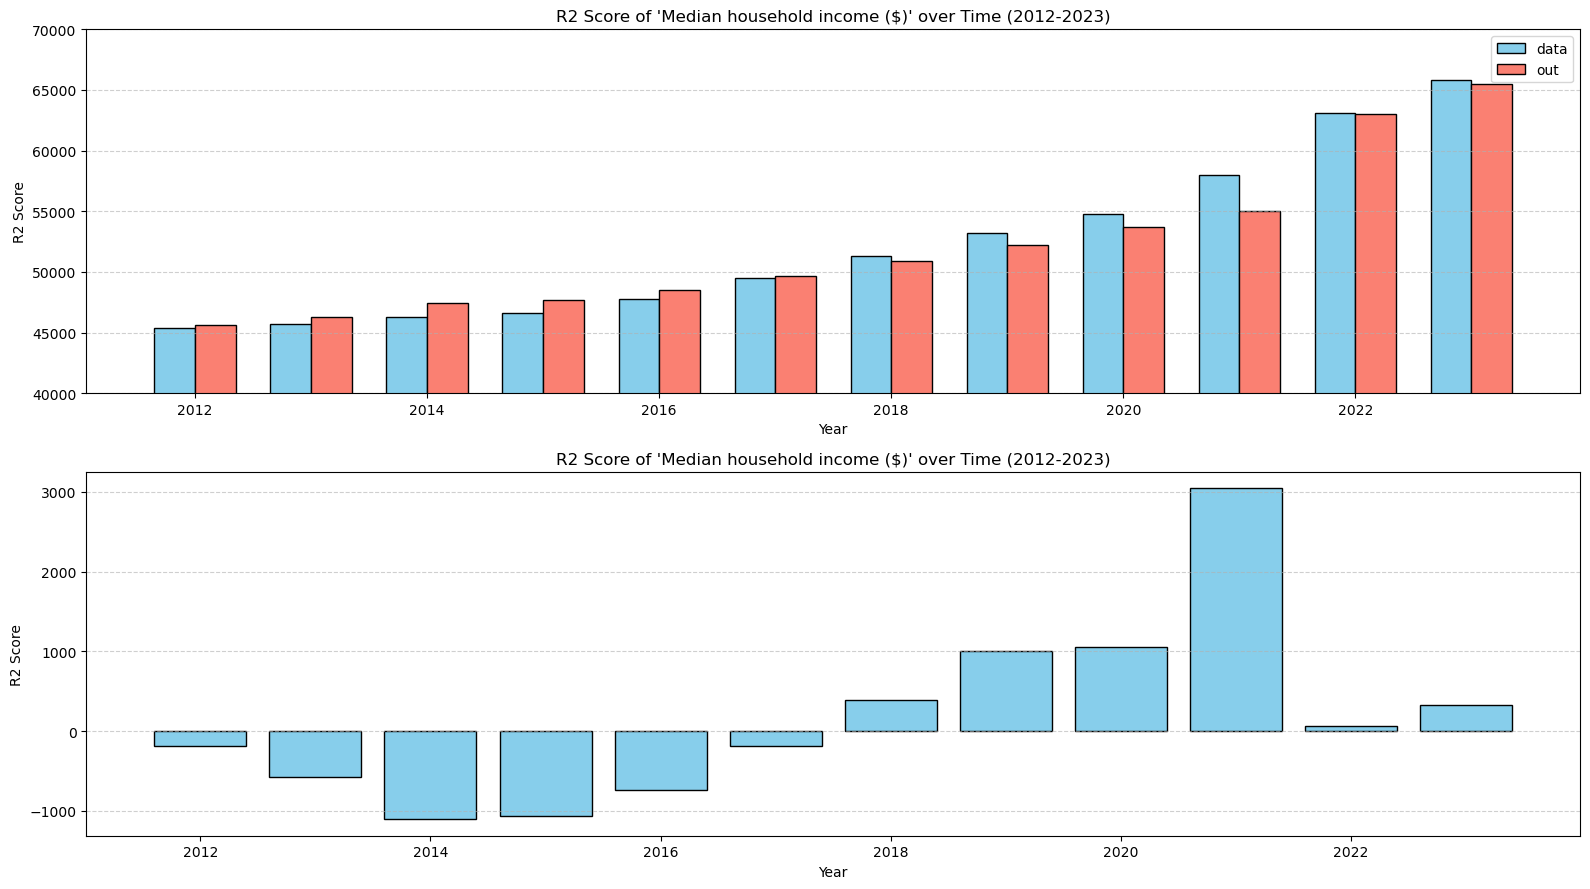

In [68]:
fig, ax = plt.subplots(2, 1, figsize=(16, 9))
ax = ax.flatten()

width = 0.35

ax[0].bar(years - width/2, m_data_y_by_year, width, label='data', color='skyblue', edgecolor="black")
ax[0].bar(years + width/2, m_output_by_year, width, label='out', color='salmon', edgecolor="black")
ax[0].legend()

ax[1].bar(years, m_data_y_by_year - m_output_by_year, label='data', color='skyblue', edgecolor="black")

ax[0].grid(True, axis='y', linestyle='--', alpha=0.6)
ax[1].grid(True, axis='y', linestyle='--', alpha=0.6)

ax[0].set_ylim(40000, 70000)

ax[0].set_title("R2 Score of 'Median household income ($)' over Time (2012-2023)")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("R2 Score")

ax[1].set_title("R2 Score of 'Median household income ($)' over Time (2012-2023)")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("R2 Score")

fig.tight_layout()

In [46]:
gdf = gpd.read_file("../../Data/Shapefiles/tl_2023_us_county.shp")
gdf = gdf[["GEOIDFQ", "geometry"]]

geoid_order = list(dict_x.keys())
geoid_index = {geoid: index for index, geoid in enumerate(geoid_order)}

In [47]:
gdf_filtered = gdf[gdf['GEOIDFQ'].isin(geoid_order)].copy()
gdf_filtered['GEOIDFQ_rank'] = gdf_filtered['GEOIDFQ'].map(geoid_index)

gdf_sorted = gdf_filtered.sort_values('GEOIDFQ_rank')

In [48]:
new_col = ["mae$", "mae%", "std$", "std%", 'out$', 'out%']

In [49]:
gdf_sorted['out$'] = m_output_by_county
gdf_sorted['mae$'] = mae_by_county
gdf_sorted['std$'] = std_by_county

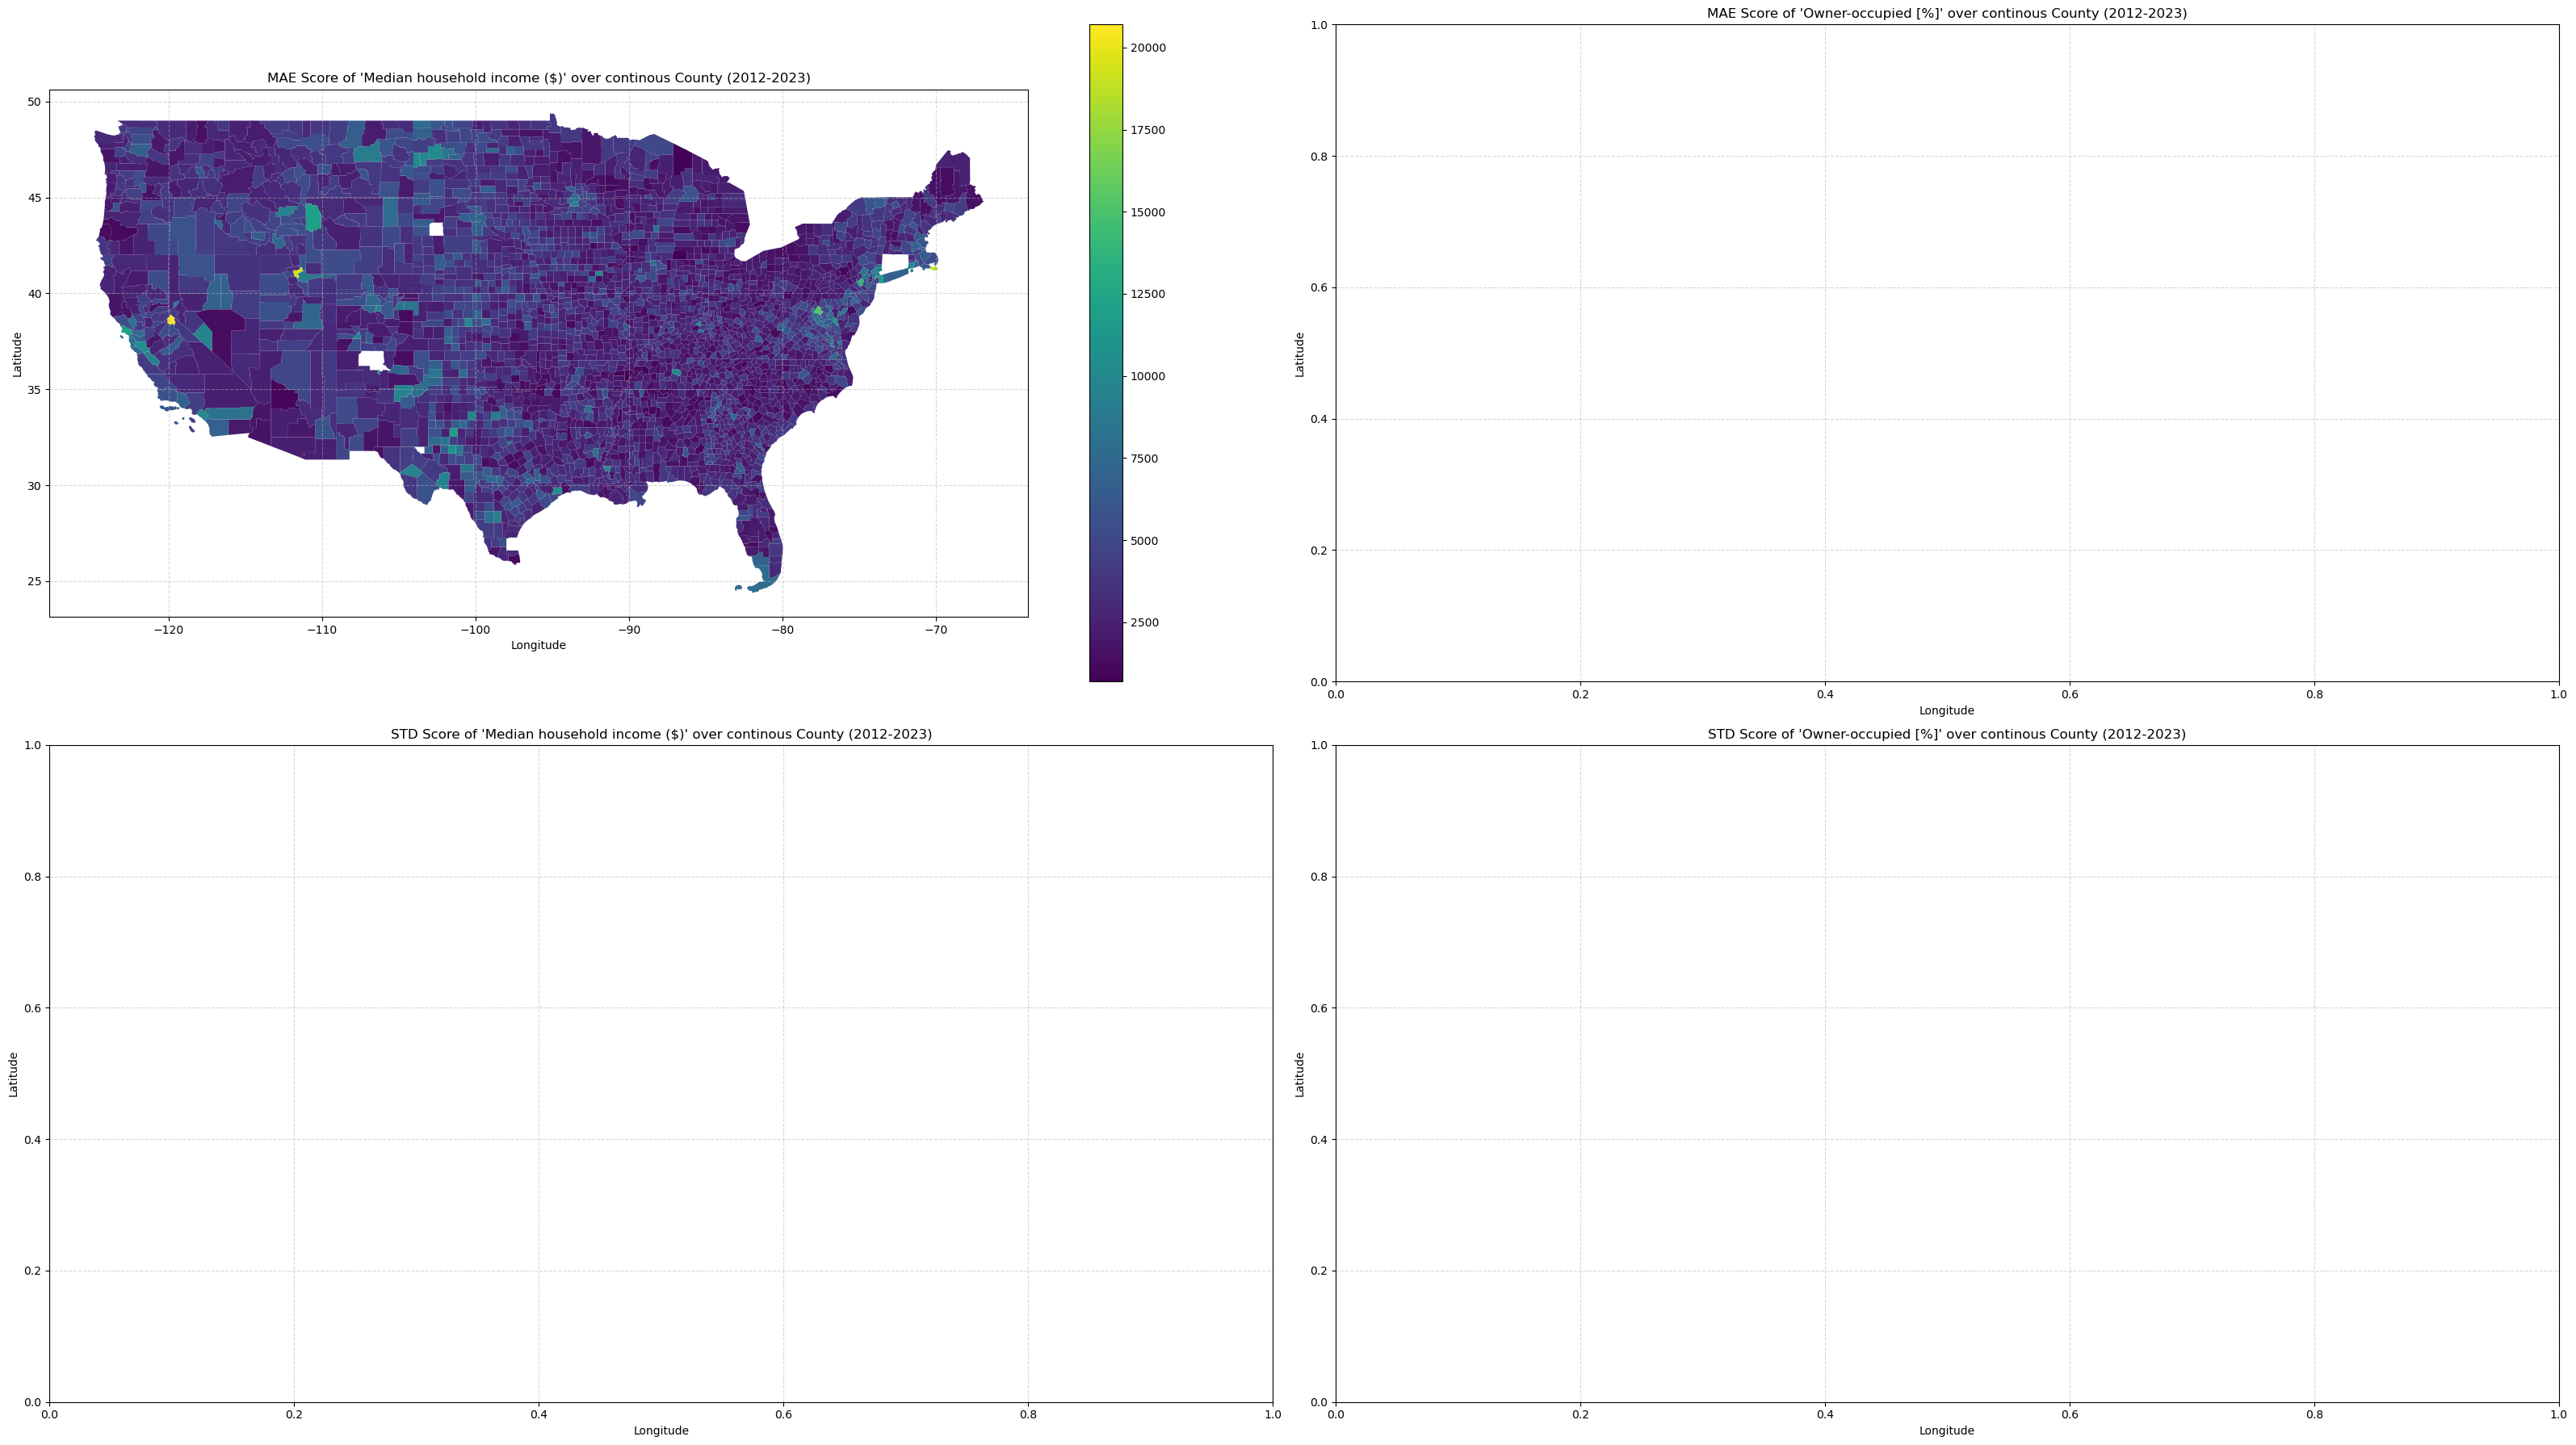

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(32, 18))
ax = ax.flatten()

gdf_sorted.plot(column=new_col[0], cmap="viridis", legend=True, ax=ax[0])
#gdf_sorted.plot(column=new_col[1], cmap="viridis", legend=True, ax=ax[1])
#gdf_sorted.plot(column=new_col[2], cmap="viridis", legend=True, ax=ax[2])
#gdf_sorted.plot(column=new_col[3], cmap="viridis", legend=True, ax=ax[3])

ax[0].set_title("MAE Score of 'Median household income ($)' over continous County (2012-2023)")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")

ax[1].set_title("MAE Score of 'Owner-occupied [%]' over continous County (2012-2023)")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

ax[2].set_title("STD Score of 'Median household income ($)' over continous County (2012-2023)")
ax[2].set_xlabel("Longitude")
ax[2].set_ylabel("Latitude")

ax[3].set_title("STD Score of 'Owner-occupied [%]' over continous County (2012-2023)")
ax[3].set_xlabel("Longitude")
ax[3].set_ylabel("Latitude")

ax[0].grid(True, linestyle='--', alpha=0.5)
ax[1].grid(True, linestyle='--', alpha=0.5)
ax[2].grid(True, linestyle='--', alpha=0.5)
ax[3].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()